# Visualization

In [124]:
%matplotlib inline 

import re
import sqlite3
import numpy as np
import pandas as pd
import missingno as msno # Visualization

# File with functions
from p2func import my_print_function

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import pylab
import seaborn as sns
sns.set_context("poster", font_scale=1.3)

### Functions

In [511]:
'''
analyse_meal_info_and_meal_ing(meal_info, meal_ing, cat_meal)
    Creates a list with individual categories as columns showing the proportion of the ingredient with respect to its category
    Adjacent columns will show that ingredient's place in the top list of that category, these number can repeat themselves as 
    there can be the same proportion of onions and butter in a single category. 
    Returns the dataframe with these columns for further analysis. 
    The following dataframe is built with columns named as their category having normalized values representing the number of times 
    the ingredient is in every meal of that category. 
    The Columns named as 'category_pod' represent the place that the ingredient has in the category's top list. This is to show 
    the results if we consider every category having the same weight regardless of their number of meals. 

save_3_tables(dbname, meal_info, meal_ing, ingredients):
    Saves the 3 tables in the dbname.sqlite.

load_3_dataframes :
    Receives the name of the sqlitefile
    Returns the specific 3 tables: meal_info, meal_ing and ingredients
    as dataframes.

show_db_tables
    Receives as parameter the name of the sqlite file
    Prints out the tables the database has.'''

def analyse_meal_info_and_meal_ing(meal_info, meal_ing, cat_meal):
    cat_ing = ['bacon','chorizo','cod','chicken','steaks','shrimp','salmon','sausage','beef','turkey',
           'fish','trout','tilapia','pork','prosciutto','meatball','lamb']
    tx = pd.DataFrame()
    for i in range(len(meal_info.Category.unique())):
        # Get a category:
        ctgry = meal_info.Category.value_counts().index[i]
        # Get the number of meals in the category
        total_meals = cat_meal.loc[ctgry].shape[0]
        # Top list
        top_list = meal_ing.loc[meal_ing.Meal_id.isin(cat_meal.loc[(ctgry)].index),['Ming']].Ming.value_counts()
        # Normalize 
        top_list = top_list.apply(lambda x: int(x/total_meals*100))
        # Apply Threshold
        top_list = top_list.apply(lambda x: min(x,100))
        # Remove the category's main ingredient (i.e. pork removed from pork category)
        try:
            ind = [i for i, x in enumerate(top_list.index.isin(cat_ing)) if x]
            top_list.drop(top_list[ind].index, inplace=True)
        except: 
            pass

        # Set up the spots in the podium
        t_temp = pd.DataFrame()
        t_temp[ctgry+'%'] = top_list
        podium = 1
        pod = [1]
        for row in range(1,len(t_temp.values)):
            if t_temp.values[row-1]!=t_temp.values[row]:
                podium += 1
            pod.append(podium)

        t_temp[ctgry+'_position'] = pod
        tx = pd.concat([tx,t_temp], axis=1)
    col_percentage = np.arange(1,meal_info.Category.value_counts().count()*2,2)
    # This new column will show the number of categories in which the ingredients are present. 
    tx['category_presence'] = tx.iloc[:,col_percentage].count(axis=1)
    # This column below will have the average proportion of the ingredient in all its categories 
    #tx['normalized'] = tx.iloc[:,np.arange(0,18,2)].sum(axis=1)/meal_info.Category.value_counts().count()
    tx['normalized'] = tx.iloc[:,col_percentage-1].sum(axis=1)/tx.category_presence

    return tx

def load_3_dataframes(db_name = 'project2.sqlite'):
    table_name_1  = 'meal_info'
    table_name_2  = 'meal_ing'
    table_name_3  = 'ingredients'
    id_field      = 'meal_id'
    show_db_tables(db_name)
    q1 = 'SELECT * FROM {tn} ORDER BY {idf}'.format(tn=table_name_1, idf=id_field)
    q2 = 'SELECT * FROM {tn} ORDER BY {idf}'.format(tn=table_name_2, idf=id_field)
    q3 = 'SELECT * FROM {tn}'.format(tn=table_name_3)
    conn = sqlite3.connect(db_name)
    # Load Meal_info Dataframe
    meal_info = pd.read_sql_query(q1, conn)
    meal_info = meal_info.drop('index', axis=1)
    # Load Meal_ing Dataframe
    meal_ing = pd.read_sql_query(q2, conn)
    meal_ing = meal_ing.drop('index', axis=1)
    # Load Ingredients Dataframe
    ingredients = pd.read_sql_query(q3, conn)
    ingredients = ingredients.drop('index', axis=1)
    conn.close()
    return meal_info, meal_ing, ingredients

def save_3_tables(db_name, meal_info, meal_ing, ingredients):
    conn = sqlite3.connect(db_name)
    meal_info.to_sql("meal_info", conn, if_exists="replace")
    meal_ing.to_sql("meal_ing", conn, if_exists="replace")
    ingredients.to_sql("ingredients", conn, if_exists="replace")
    conn.commit()
    conn.close()
    print('Tables Saved to',db_name)

def show_db_tables(db_name):
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    query_check  = 'SELECT name FROM sqlite_master WHERE type= "table";'
    c.execute(query_check)
    table_set = [item[0] for item in c.fetchall()]
    print(table_set)

### Load the Info onto dataframes

In [502]:
db_name = 'datasets/project2.sqlite'
meal_info, meal_ing, ingredients = load_3_dataframes(db_name)

['meal_info', 'meal_ing', 'ingredients']


In [113]:
save_3_tables('project2.sqlite', meal_info, meal_ing, ingredients)

Tables Saved to project2.sqlite


/Users/iZbra1/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:1534: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


# The Dataset
### Describe the Panel
#### 168 meals using some of the 188 unique ingredients listed by Homechef

In [503]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
ing_id    189 non-null object
Ming      189 non-null object
dtypes: object(2)
memory usage: 3.0+ KB


In [541]:
meal_info.Duration.describe()

count    168.000000
mean      55.440476
std        9.792887
min       12.000000
25%       47.000000
50%       55.000000
75%       62.000000
max       85.000000
Name: Duration, dtype: float64

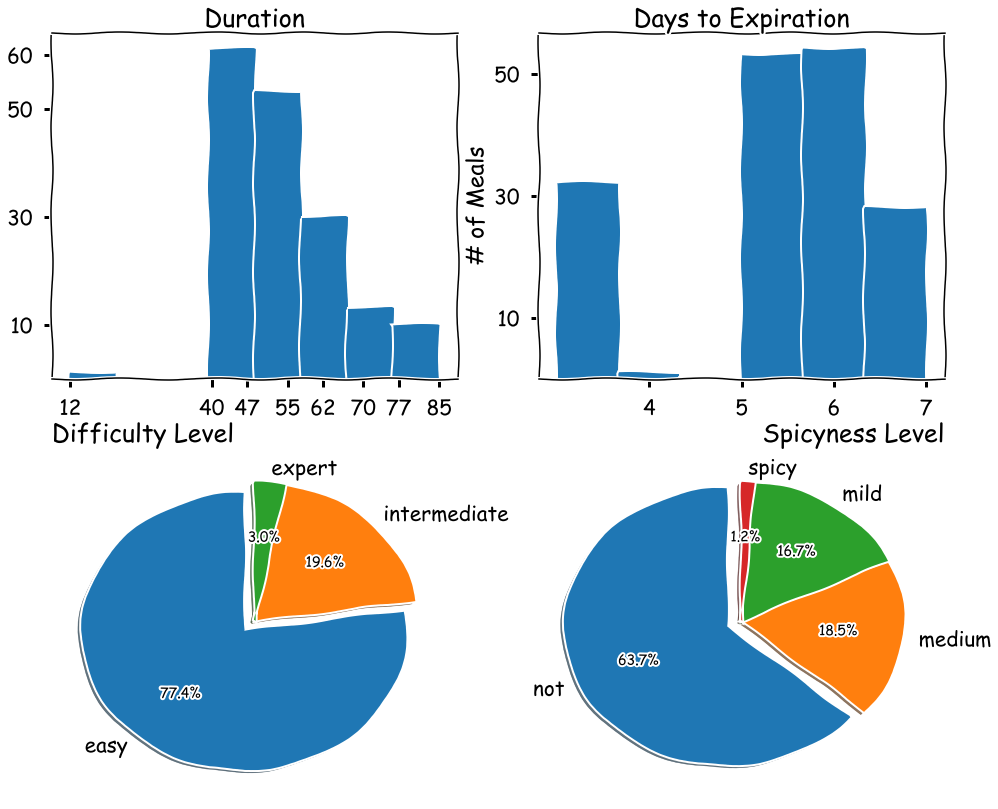

In [557]:
with plt.xkcd():
    fig1 = plt.figure(figsize = (16,14))
    ax1 = fig1.add_subplot(2,2,1)
    plt.hist(meal_info.Duration, bins=8)
    ax1.set_xticks(meal_info.Duration.value_counts().index)
    ax1.set_yticks([10,30,50,60])
    plt.title('Duration')


    ax2 = fig1.add_subplot(2, 2, 2)
    plt.hist(meal_info['Days To Expiration'], bins=6)
    ax2.set_xticks(range(4,8))
    ax2.set_yticks([10,30,50])
    plt.title('Days to Expiration')
    plt.ylabel('# of Meals')


    ax3 = fig1.add_subplot(2, 2, 3)
    common_ing = meal_info.Expertise.value_counts()
    labels = list(common_ing.index)
    sizes = list(common_ing.values)
    explode = np.zeros(len(common_ing))
    explode[np.argmax(sizes)] = 0.1 
    ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.title('Difficulty Level', loc='left')


    ax4 = fig1.add_subplot(2, 2, 4)
    common_ing = meal_info.Spicyness.value_counts()
    labels = list(common_ing.index)
    sizes = list(common_ing.values)
    explode = np.zeros(len(common_ing))
    explode[np.argmax(sizes)] = 0.1 
    ax4.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.title('Spicyness Level', loc='right')

plt.show()
fig1.savefig('img/SecondaryMetrics.png', bbox_inches='tight')

#### In average, most of meals:
1. have a cooking time of 55 minutes
2. Contain ingredients perishable within 6 days

#### Moreover 
1. 77% are easy meals and just 3% are difficult. Since the website focuses on easy-to-follow recipes, it's logical that most of the recipes are easy
2. 63% are not spicy where as 1.2 are very spicy. 

#### The meals fall into the following categories: 
Meals based with pork are the most common meals in the Homechef database, probably due to its price. Secondly the poultry and vegetarian meals fall behind 20%. Meals based with lamb and sausage have only one count in the database. In conclusion there are not enough meals from the minor categories to make the Homechef's dataset uniform. Pork-based meals will have the most common ingredients and viceversa most common ingredients will be present in the pork-based meals. 

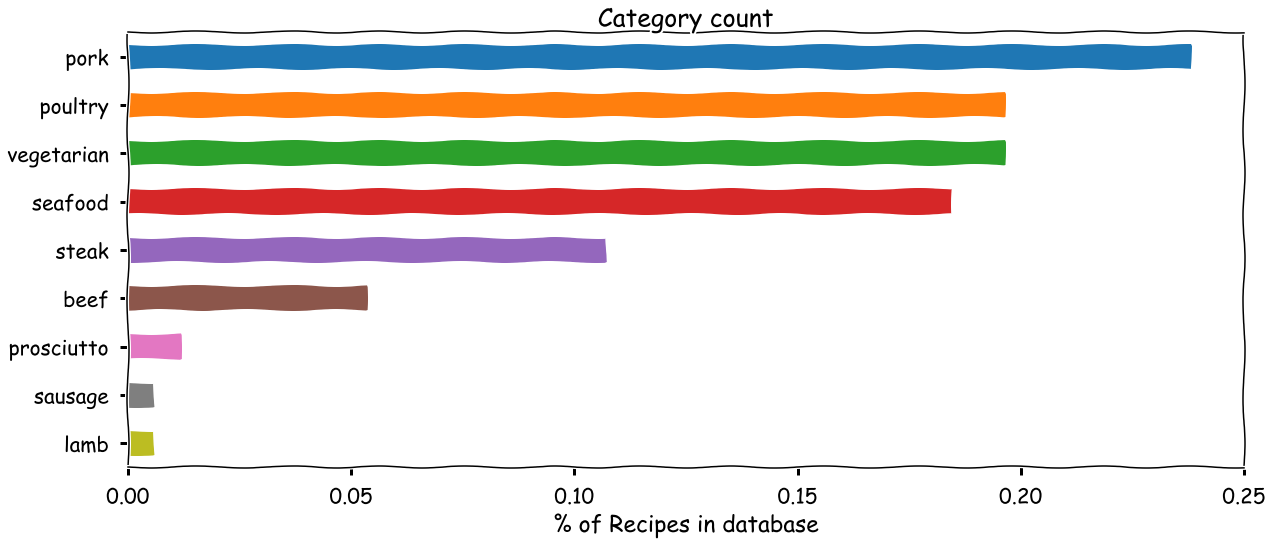

In [505]:
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(20,8))
    mc = meal_info.Category.value_counts()/len(meal_info)
    mc.plot(kind='barh')
    plt.xlabel('% of Recipes in database')
    plt.title('Category count')
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.show()
    fig.savefig('img/CategoryCount.png', bbox_inches='tight')

### Further exploration: 
#### In average each meal consists of 8.7 different ingredients give or take 1.3

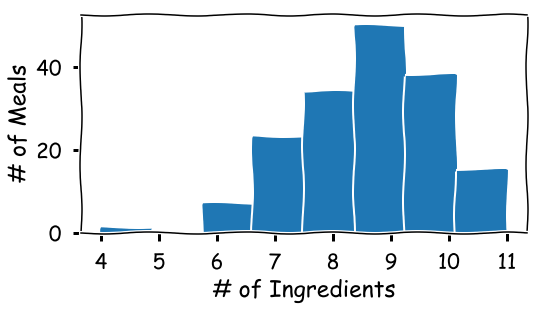

In [506]:
with plt.xkcd():
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(meal_ing.Meal_id.value_counts(),bins=8)
    ax.set_xticks(range(4,12))
    plt.xlabel('# of Ingredients')
    plt.ylabel('# of Meals')
    plt.show()
    fig.savefig('AverageNumberIngredients.png', bbox_inches='tight')

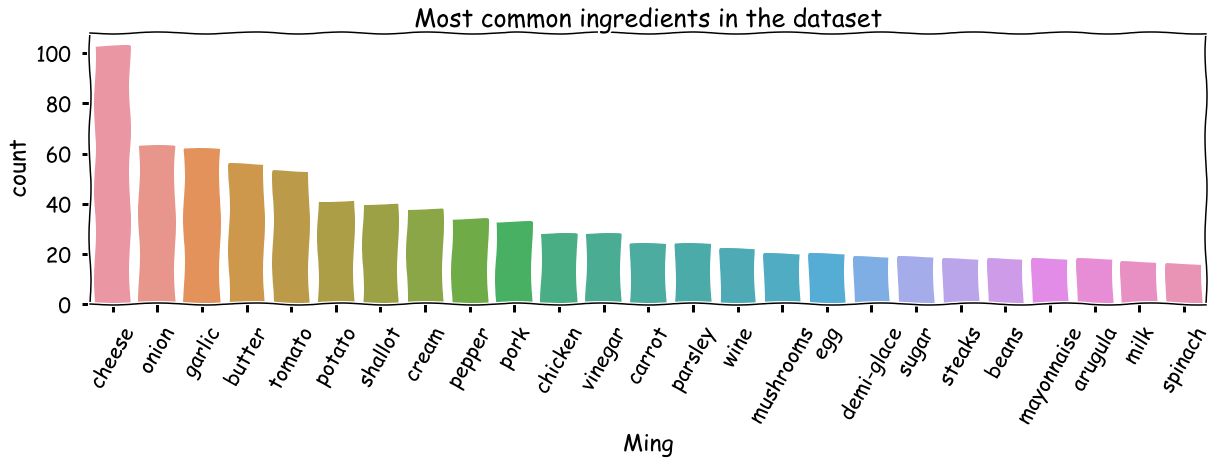

In [507]:
with plt.xkcd():
    fig = plt.figure(figsize=(20,5))
    sns.countplot(x="Ming", data=meal_ing, order = meal_ing['Ming'].value_counts()[:25].index)
    plt.xticks(rotation=60)
    plt.title('Most common ingredients in the dataset')
    plt.show()
    fig.savefig('img/commonIngredients.png', bbox_inches='tight')

## Common ingredients per Category

In [512]:
# Dataframe with all the meal_id's grouped by category:
cat_meal = meal_info.groupby(['Category','Meal_id']).size()
# Get the chart with the analysis: 
tx = analyse_meal_info_and_meal_ing(meal_info, meal_ing, cat_meal)

### Print again the top 25 ingredients which are now normalized. 

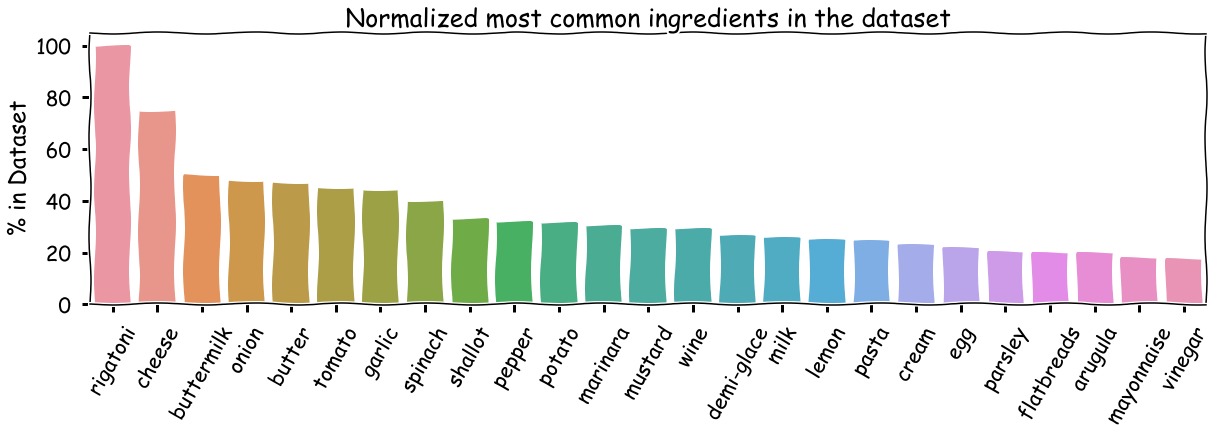

In [514]:
normalized_top_list = tx.normalized.sort_values(ascending=False)
with plt.xkcd():
    fig = plt.figure(figsize=(20,5))
    sns.barplot(x=normalized_top_list.sort_values(ascending=False)[:25].index,y=normalized_top_list.sort_values(ascending=False)[:25].values)
    plt.xticks(rotation=60)
    plt.ylabel('% in Dataset')
    plt.title('Normalized most common ingredients in the dataset')
    plt.show()
    fig.savefig('img/NormalizedcommonIngredients.png', bbox_inches='tight')

## Implementing the Grading system
### Proving that *"presence in most categories"* beats *"normalization"*

In [515]:
col_percentage = np.arange(0,meal_info.Category.value_counts().count()*2+1,2)
normVSpresence = tx.iloc[(tx.index=='garlic')|(tx.index=='spinach')|(tx.index=='shallot'),np.append(col_percentage, 19)].sort_values('normalized',ascending=False)

In [516]:
normVSpresence.iloc[:,:-2]

,pork%,poultry%,vegetarian%,seafood%,steak%,beef%,prosciutto%,sausage%,lamb%
garlic,30.0,30.0,42.0,58.0,27.0,22.0,NaN,100.0,NaN
spinach,10.0,6.0,21.0,3.0,NaN,NaN,NaN,100.0,100.0
shallot,20.0,27.0,30.0,22.0,22.0,11.0,NaN,NaN,100.0


**Shallot** has a higher proportion on: pork, poultry, vegetarian, seafood, steak, beef. 

**Spinach** has a higher proportion from the shallot in the only recipe of the sausage team and equal proportion in the 1-recipe category of lamb

Normalizing is useful for categories with a certain number of recipes, however like in the case of the lamb category having only 1 recipe can make its ingredients' proportion comparable to the other categories. Therefore another filter will take the head on this hierarchy and that is the number of categories the ingredient is present. 

This will make the llist look like: 

In [517]:
tx.normalized = tx.normalized/100 # Degrading the weight of the normalization filter. 
tx['total_usage'] = tx.loc[:,['category_presence', 'normalized']].sort_values(['category_presence', 'normalized'], ascending=False).sum(axis=1)

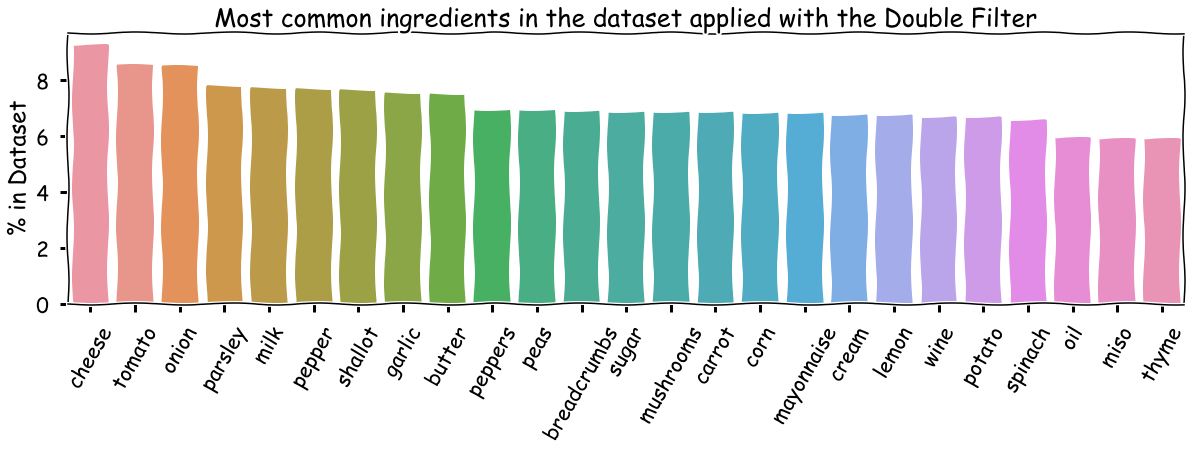

In [518]:
with plt.xkcd():
    fig = plt.figure(figsize=(20,5))
    sns.barplot(x=double_filter_list.sort_values(ascending=False)[:25].index,y=double_filter_list.sort_values(ascending=False)[:25].values)
    plt.xticks(rotation=60)
    plt.ylabel('% in Dataset')
    plt.title('Most common ingredients in the dataset applied with the Double Filter')
    plt.show()
    fig.savefig('img/DoubleFilterCommonIngredients.png', bbox_inches='tight')

#### Tomato vs Onion

In [519]:
tx.loc[(tx.index=='tomato')|(tx.index=='onion'),:]

,pork%,pork_position,poultry%,poultry_position,vegetarian%,vegetarian_position,seafood%,seafood_position,steak%,steak_position,...,beef_position,prosciutto%,prosciutto_position,sausage%,sausage_position,lamb%,lamb_position,category_presence,normalized,total_usage
onion,40.0,2.0,30.0,5.0,30.0,5.0,38.0,3.0,50.0,4.0,...,3.0,50.0,2.0,100.0,1.0,NaN,NaN,8,0.47750,8.47750
tomato,5.0,13.0,45.0,2.0,54.0,2.0,41.0,2.0,5.0,10.0,...,6.0,100.0,1.0,NaN,NaN,100.0,1.0,8,0.45125,8.45125


## Results

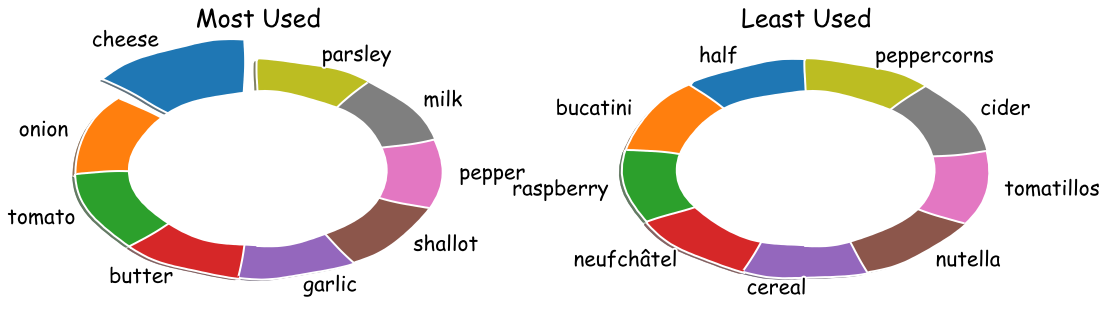

In [524]:
with plt.xkcd():
    fig1 = plt.figure(figsize = (18,5))
    ax1 = fig1.add_subplot(1,2,1)
    # Most used
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig1 = plt.gcf()
    fig1.gca().add_artist(centre_circle) 
    labels = tx.total_usage.sort_values(ascending=False).head(9).index
    sizes = tx.total_usage.sort_values(ascending=False).head(9).values
    explode = np.zeros(9)
    explode[np.argmax(sizes)] = 0.2 
    ax1.pie(sizes, explode=explode, labels=labels,
        shadow=True, startangle=90)
    plt.title('Most Used')
    ax2 = fig1.add_subplot(1, 2, 2)
    # Least used
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig1 = plt.gcf()
    fig1.gca().add_artist(centre_circle) 
    labels = tx.total_usage.sort_values(ascending=False).tail(9).index
    sizes = tx.total_usage.sort_values(ascending=False).tail(9).values
    explode = np.zeros(9)
    explode[np.argmax(sizes)] = 0.2 
    ax2.pie(sizes, labels=labels,
        shadow=True, startangle=90)
    plt.title('Least Used')
plt.show()

# Now the grand finale: 
Find those meals that are easy and fast (and have the longest expiration period) and plot their common ingredients
Compare the list with those meals that are nos easy and slow. 

### Number of meals that are fast and easy vs slow and difficult:

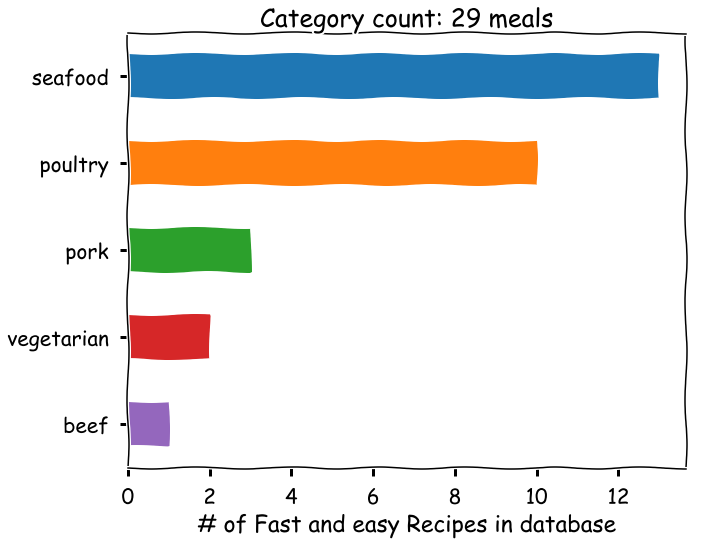

In [548]:
slow_and_difficult = meal_info.loc[(meal_info.Expertise != 'easy') & (meal_info.Duration > 47)].sort_values('Duration')
mc_sd = meal_info.loc[meal_info.Meal_id.isin(slow_and_difficult.Meal_id.values),['Category']]

fast_and_easy = meal_info.loc[(meal_info.Expertise == 'easy') & (meal_info['Days To Expiration'] <= 5) & (meal_info.Duration <= 47)].sort_values('Duration')
mc_fe = meal_info.loc[meal_info.Meal_id.isin(fast_and_easy.Meal_id.values),['Category']]
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(10,8))
    mc = mc_fe.Category.value_counts()
    mc.plot(kind='barh')
    plt.xlabel('# of Fast and easy Recipes in database')
    plt.title('Category count: '+str(fast_and_easy.shape[0])+' meals')
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.show()
    fig.savefig('img/Fast&EasyCategoryCount.png', bbox_inches='tight')

In [550]:
cat_meal = fast_and_easy.groupby(['Category','Meal_id']).size()
# Get the cthe analysis: 
tx_fe = analyse_meal_info_and_meal_ing(fast_and_easy, meal_ing, cat_meal)
tx_fe.normalized = tx_fe.normalized/100 # Degrading the weight of the normalization filter. 
tx_fe['total_usage'] = tx_fe.loc[:,['category_presence', 'normalized']].sort_values(['category_presence', 'normalized'], ascending=False).sum(axis=1)

# Get the Slow and Difficult top list
cat_meal = slow_and_difficult.groupby(['Category','Meal_id']).size()
tx_sd = analyse_meal_info_and_meal_ing(slow_and_difficult, meal_ing, cat_meal)
tx_sd.normalized = tx_sd.normalized/100 # Degrading the weight of the normalization filter. 
tx_sd['total_usage'] = tx_sd.loc[:,['category_presence', 'normalized']].sort_values(['category_presence', 'normalized'], ascending=False).sum(axis=1)


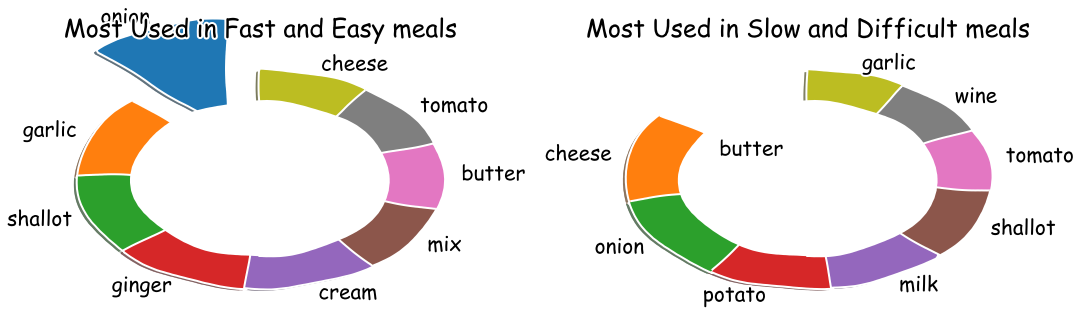

In [556]:
with plt.xkcd():
    fig1 = plt.figure(figsize = (18,7))
    ax1 = fig1.add_subplot(1,2,1)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle) 
    # Most used
    labels = tx_fe.total_usage.sort_values(ascending=False).head(9).index
    sizes = tx_fe.total_usage.sort_values(ascending=False).head(9).values
    explode = np.zeros(9)
    explode[np.argmax(sizes)] = 0.2
    ax1.pie(sizes, explode=explode, labels=labels,
        shadow=True, startangle=90)
    plt.title('Most Used in Fast and Easy meals')
    
    ax2 = fig1.add_subplot(1, 2, 2)
    # Least used
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig1 = plt.gcf()
    fig1.gca().add_artist(centre_circle) 
    labels = tx_sd.total_usage.sort_values(ascending=False).head(9).index
    sizes = tx_sd.total_usage.sort_values(ascending=False).head(9).values
    explode = np.zeros(9)
    explode[np.argmax(sizes)] = 0.2 
    ax2.pie(sizes, explode=explode, labels=labels,
        shadow=True, startangle=90)
    plt.title('Most Used in Slow and Difficult meals')
plt.show()
fig.savefig('img/Fast&EasyVSSlow&Difficult.png', bbox_inches='tight')

## Plotting normalized top 9 lists per category. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ctgry = meal_info.Category.value_counts().index[0]
total_meals = cat_meal.loc[ctgry].shape[0]    
tl = tx.loc[tx[ctgry+'%'].notnull(),[ctgry+'%']].sort_values(ctgry+'%',ascending=False)
tl.head(9).plot(kind='barh')

ctgry = meal_info.Category.value_counts().index[1]
total_meals = cat_meal.loc[ctgry].shape[0]    
tl = tx.loc[tx[ctgry+'%'].notnull(),[ctgry+'%']].sort_values(ctgry+'%',ascending=False)
tl.head(9).plot(kind='barh')
plt.show()

fig1 = plt.figure(figsize = (5,5))

ax1 = fig1.add_subplot(2,1,1)
ctgry = meal_info.Category.value_counts().index[0]
total_meals = cat_meal.loc[ctgry].shape[0]    
tl = tx.loc[tx[ctgry+'%'].notnull(),[ctgry+'%']].sort_values(ctgry+'%',ascending=False)
tl.head(9).plot(kind='barh')
ax2 = fig1.add_subplot(2, 1, 2)
ctgry = meal_info.Category.value_counts().index[1]
total_meals = cat_meal.loc[ctgry].shape[0]    
tl = tx.loc[tx[ctgry+'%'].notnull(),[ctgry+'%']].sort_values(ctgry+'%',ascending=False)
tl.head(9).plot(kind='barh')

fig = plt.figure()#figsize=(30,35)
for i in range(len(meal_info.Category.unique())):
    print(i)
    fig.add_subplot(3, 3, i+1)
    ctgry = meal_info.Category.value_counts().index[i]
    total_meals = cat_meal.loc[ctgry].shape[0]    
    tl = tx.loc[tx[ctgry+'%'].notnull(),[ctgry+'%']].sort_values(ctgry+'%',ascending=False)
    tl.head(9).plot(kind='barh')
#        plt.title(ctgry,': ',str(total_meals)+' recipes')
#        plt.xlabel('% in all pork recipes')
#fig.savefig('img/commonIngredientsPork.png', bbox_inches='tight')

# Further research
*What could be the proportion of these ingredients? In the optics of knowing what to always have in the kitchen, we should also know how much, so maybe an estimate of how much of these ingredients are required in the recipes.*

*Use of the "TYPE" of ingredients to see how much an ingredient can vary. The higher the variance the more likely the ingredient will appear in the meal? Take cheese for example, it's the most commonn ingredient because it has many types of it. There are some meals that even include at least 2 types of cheese

---

### Duration (Time spent cooking) 

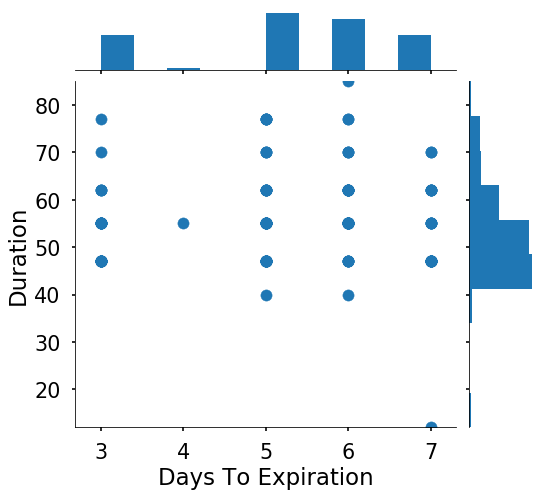

In [157]:
svr = [meal_info['Days To Expiration'].min(), meal_info['Days To Expiration'].max()]
gdpr = [(meal_info.Duration.min()), meal_info.Duration.max()] 

g =sns.JointGrid(x="Days To Expiration", y="Duration", data=meal_info, ylim=gdpr)
g.ax_marg_x.hist(meal_info['Days To Expiration'], range=svr)
g.ax_marg_y.hist(meal_info.Duration, range=gdpr, bins=10, orientation="horizontal")
g.plot_joint(plt.scatter)
ax = g.ax_joint
g.fig.set_figheight(8)
g.fig.set_figwidth(9)

### Correlation

In [159]:
meal_info_corr = meal_info.corr().loc['Duration'].drop(['Duration'])

In [160]:
meal_info_corr

Meal_id               0.138137
Rating                0.258290
Days To Expiration    0.015829
Name: Duration, dtype: float64

In [169]:
def conditional_bar(series, bar_colors=None, color_labels=None, figsize=(13,5),
                   xlabel=None, by=None, ylabel=None, title=None):
    fig, ax  = plt.subplots(figsize=figsize)
    if not bar_colors:
        bar_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.barh(range(len(series)),series.values, color=bar_colors)
    plt.xlabel('' if not xlabel else xlabel);
    plt.ylabel('' if not ylabel else ylabel)
    plt.yticks(range(len(series)), series.index.tolist())
    plt.title('' if not title else title);
    plt.ylim([-1,len(series)]);
    if color_labels:
        for col, lab in color_labels.items():
            plt.plot([], linestyle='',marker='s',c=col, label= lab);
        lines, labels = ax.get_legend_handles_labels();
        ax.legend(lines[-len(color_labels.keys()):], labels[-len(color_labels.keys()):], loc='upper right');
    plt.close()
    return fig

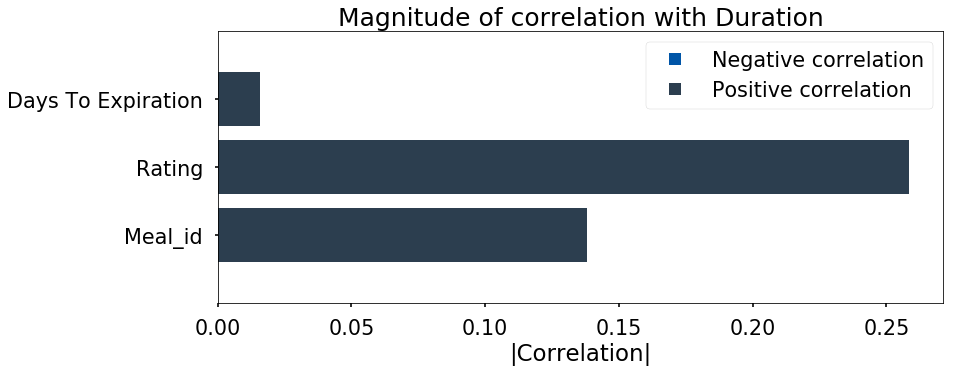

In [170]:
bar_colors = ['#0055A7' if x else '#2C3E4F' for x in list(meal_info_corr.values < 0)]
color_labels = {'#0055A7':'Negative correlation', '#2C3E4F':'Positive correlation'}

conditional_bar(meal_info_corr.apply(np.abs), bar_colors, color_labels,
               title='Magnitude of correlation with Duration',
               xlabel='|Correlation|')

Are there any direct relationships between fields (e.g. a value of x always implies a specific value of y)?

**No**